## **Plantilla**

In [1]:
import pandas as pd

ruta = "https://raw.githubusercontent.com/VillaltaE/netflix_churn/refs/heads/main/netflix_customer_churn.csv"
df = pd.read_csv(ruta)

model_cols = [
    "subscription_type",
    "watch_hours",
    "last_login_days",
    "monthly_fee",
    "number_of_profiles",
    "avg_watch_time_per_day",
    "payment_method"
]

X = df[model_cols]
y = df["churned"]

X.head(), y.value_counts(normalize=True)


(  subscription_type  watch_hours  last_login_days  monthly_fee  \
 0             Basic        14.73               29         8.99   
 1          Standard         0.70               19        13.99   
 2          Standard        16.32               10        13.99   
 3           Premium         4.51               12        17.99   
 4          Standard         1.89               13        13.99   
 
    number_of_profiles  avg_watch_time_per_day payment_method  
 0                   1                    0.49      Gift Card  
 1                   5                    0.03      Gift Card  
 2                   2                    1.48         Crypto  
 3                   2                    0.35         Crypto  
 4                   2                    0.13         Crypto  ,
 churned
 1    0.503
 0    0.497
 Name: proportion, dtype: float64)

## **Importar lo necesario**

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt



## **Definir columnas por tipo**



In [3]:
categorical_cols = ["subscription_type","payment_method"]
numeric_cols = [
    "watch_hours",
    "last_login_days",
    "monthly_fee",
    "number_of_profiles",
    "avg_watch_time_per_day"
]


### **Preprocesador: Codificación y Escalamiento de las variables**

In [4]:
preprocesador = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop='first', handle_unknown="ignore"), categorical_cols),
        ("num", RobustScaler(), numeric_cols)
    ],
    remainder= "passthrough"
)

## **Train/Validation/Test split (80/20)**

In [5]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=42, stratify=y)

In [7]:
X_test.shape, X_test.shape

((1000, 7), (1000, 7))

### **Crear el pipeline**

In [8]:
#Instanciamos el modelo
modelo_rl = LogisticRegression(random_state=42, max_iter=1000)

In [9]:
pipeline = Pipeline(steps=[
    ('preprocesador', preprocesador),
    ('modelo_rl', modelo_rl)
])

## **Entrenar**

In [10]:
#Entrenamos con los datos de entenamiento
lr = pipeline.fit(X_train, y_train)


In [11]:
#Métrica del modelo de entrenamiento
print(f'La exactidud del modelo de entrenamiento es {round(lr.score(X_train,y_train),2)}')


La exactidud del modelo de entrenamiento es 0.91


In [12]:
#Creamos un df con los datos de entrenamiento codificados y escalados
nombre_columnas = lr.named_steps['preprocesador'].get_feature_names_out()
valores_columnas = lr.named_steps['preprocesador'].transform(X_train)
df_codificado = pd.DataFrame(valores_columnas, columns= nombre_columnas)

In [13]:
df_codificado.head()

,cat__subscription_type_Premium,cat__subscription_type_Standard,cat__payment_method_Crypto,cat__payment_method_Debit Card,cat__payment_method_Gift Card,cat__payment_method_PayPal,num__watch_hours,num__last_login_days,num__monthly_fee,num__number_of_profiles,num__avg_watch_time_per_day
0,1.0,0.0,0.0,0.0,0.0,0.0,0.149555,-0.300000,0.444444,-0.5,0.262295
1,0.0,1.0,1.0,0.0,0.0,0.0,0.155094,-0.066667,0.000000,1.0,0.081967
2,0.0,0.0,1.0,0.0,0.0,0.0,-0.508803,-0.900000,-0.555556,0.0,0.213115
3,0.0,1.0,1.0,0.0,0.0,0.0,-0.431256,-0.733333,0.000000,0.0,0.000000
4,0.0,0.0,1.0,0.0,0.0,0.0,0.059347,-0.233333,-0.555556,0.0,0.114754


### **Analisis de multicolinealidad entre variables del modelo** 

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [15]:
df_vif = df_codificado.copy()
vif_data = pd.DataFrame()
vif_data['feature'] = df_vif.columns

vif_data['VIF'] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

In [16]:
vif_data

,feature,VIF
0,cat__subscription_type_Premium,6.219748
1,cat__subscription_type_Standard,2.458230
2,cat__payment_method_Crypto,1.609807
3,cat__payment_method_Debit Card,1.619348
4,cat__payment_method_Gift Card,1.617965
5,cat__payment_method_PayPal,1.648973
6,num__watch_hours,1.180053
7,num__last_login_days,1.197609
8,num__monthly_fee,3.888912
9,num__number_of_profiles,1.003297


El análisis de multicolinealidad muestra valores de VIF bajos (menores a 5) para la mayoría de las variables, garantizando su independencia. La columna subscription_type_Premium presenta un VIF de 6.22; aunque supera el umbral teórico de 5, se decidió mantenerla para evitar la pérdida de información estratégica sobre el segmento de mayor valor.


### **Balanceo de datos**

Los datos de entrenamiento no requieren el paso de balanceo dado que las dos clases de churn se encuentran equilibradas.

In [17]:
df.churned.value_counts(normalize=True)

,proportion
churned,
1,0.503
0,0.497


## **Validación de los modelos**

### Reporte de clasificación con los datos de validación

In [18]:
y_pred = lr.predict(X_val)
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.87      0.89       497
           1       0.87      0.91      0.89       503

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



### Matriz de confusión

In [19]:
print(confusion_matrix(y_val, y_pred))

[[431  66]
 [ 45 458]]


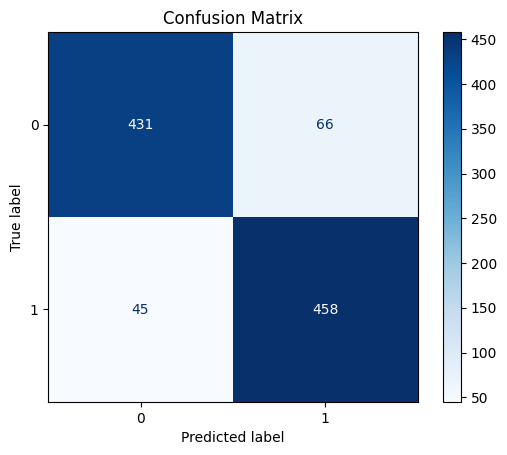

In [20]:
#Gráfico de la matriz de confusión que nos muestra que tan bien está prediciendo
visualizacion = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_pred))
visualizacion.plot(cmap='Blues');
plt.title('Confusion Matrix')

plt.show()

### Exactitud

In [21]:
print(f'La exactitud del modelo con los datos de validación es : {accuracy_score(y_val, y_pred)}')

La exactitud del modelo con los datos de validación es : 0.889


### Precisión

In [22]:
from sklearn.metrics import precision_score, recall_score

In [23]:
print(f'La precisión del modelo con los datos de validaciónes: {precision_score(y_val, y_pred)}') 

La precisión del modelo con los datos de validaciónes: 0.8740458015267175


### Sensibilidad

In [24]:
print(f'La sensibilidad del modelo con los datos de validaciónes: {recall_score(y_val, y_pred)}') 

La sensibilidad del modelo con los datos de validaciónes: 0.9105367793240556


### Curva ROC

In [25]:
print(roc_curve(y_val, y_pred))

(array([0.        , 0.13279678, 1.        ]), array([0.        , 0.91053678, 1.        ]), array([inf,  1.,  0.]))


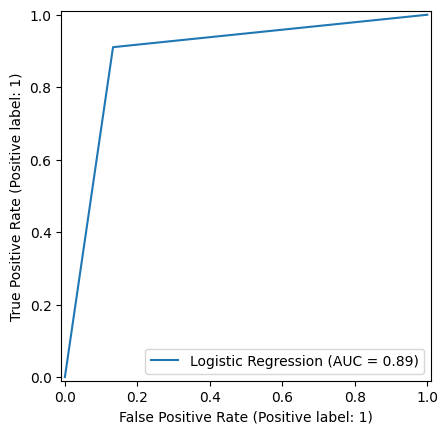

In [26]:
RocCurveDisplay.from_predictions(y_val,y_pred,name='Logistic Regression');

In [27]:
#Gráfico alternativo de la curva ROC
# Generar un predictor sin habilidad
ns_probs = [0 for _ in range(len(y_val))]
# Calculo de la métrica auc
ns_auc = roc_auc_score(y_val, ns_probs)
lr_auc = roc_auc_score(y_val, y_pred)

# Cáculo de la curva roc
ns_fpr, ns_tpr, t = roc_curve(y_val, ns_probs)
lr_fpr, lr_tpr, t = roc_curve(y_val, y_pred)




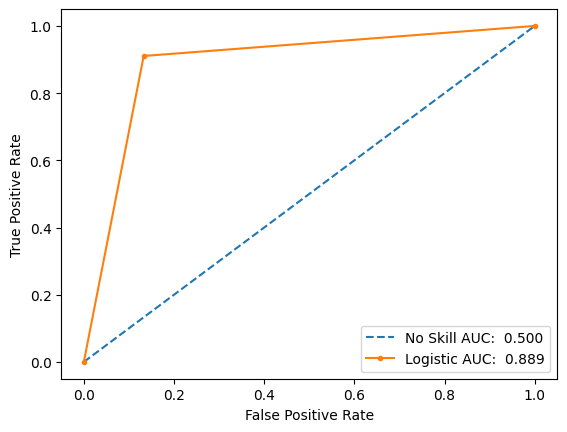

In [28]:
#Gráfico de la curva ROC
plt.plot(ns_fpr, ns_tpr, linestyle='--', label=f'No Skill AUC: {ns_auc: .3f}')
plt.plot(lr_fpr, lr_tpr, marker='.', label=f'Logistic AUC: {lr_auc: .3f}')
# Etiquetas de los ejes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Mostrar la leyenda
plt.legend()
# Mostrar el gráfico
plt.show()

### Curva Precisión Sensibilidad

In [29]:
from sklearn.metrics import PrecisionRecallDisplay

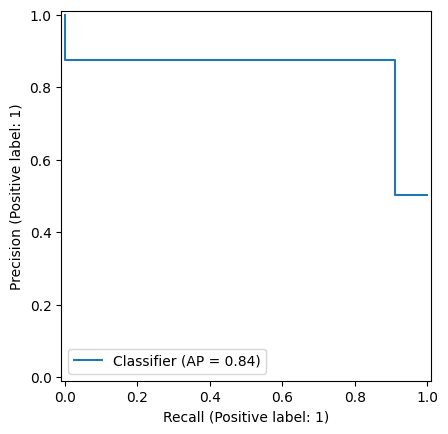

In [30]:
PrecisionRecallDisplay.from_predictions(y_val, y_pred);

In [31]:
#Cálculo de las métricas recall y precisión
lr_precision, lr_recall, _ = precision_recall_curve(y_val, y_pred)
av_pre_score = round(average_precision_score(y_val, y_pred),3)
no_skill = len(y_val[y_val==1]) / len(y_val)


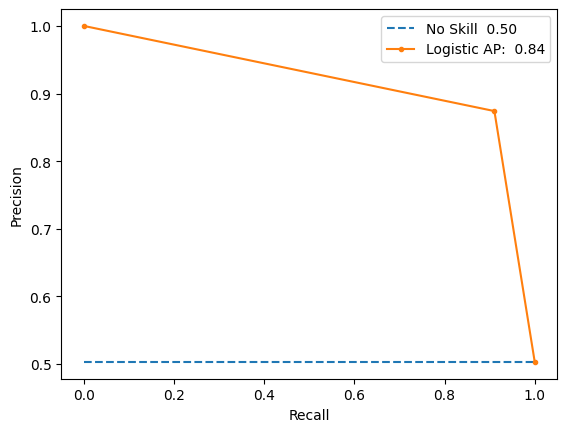

In [32]:
#Gŕafico de curva precision sensibilidad
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill {no_skill: .2f}')
plt.plot(lr_recall, lr_precision, marker='.', label= f'Logistic AP: {av_pre_score: .2f}')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()

plt.show()


### **Evaluación del modelo  con validación cruzada**

In [33]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate

In [34]:
#Separamos las columnas predictoras y la que va a ser predecida
_X = df[model_cols]

_y = df['churned']

In [35]:
_X.columns

Index(['subscription_type', 'watch_hours', 'last_login_days', 'monthly_fee',
       'number_of_profiles', 'avg_watch_time_per_day', 'payment_method'],
      dtype='object')

In [36]:
#Instanciamos el modelo
regresion = LogisticRegression(random_state=42,  class_weight='balanced', max_iter=1000)


### **Armar el pipeline para la validación cruzada**

In [37]:
#Creamos el pipeline para el modelo de regresión logística
pip_val_cruzada = Pipeline(steps=[
    ("preprocess", preprocesador),
    ("model_regression", regresion)
])


In [38]:
#Creamos el objeto skfold que se encargará de la validación cruzada
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [39]:
cross_val_regresion = cross_validate(pip_val_cruzada, _X, _y, cv=skfold, scoring=['precision','recall'])

In [40]:
cross_val_regresion

{'fit_time': array([0.03430104, 0.0307579 , 0.0520153 , 0.03027582, 0.02964783]),
 'score_time': array([0.01597309, 0.02869034, 0.01482153, 0.01553082, 0.01474404]),
 'test_precision': array([0.90854871, 0.90215264, 0.8875502 , 0.86740331, 0.90419162]),
 'test_recall': array([0.90854871, 0.91650099, 0.87872763, 0.93638171, 0.90059642])}

In [41]:
print(f'La media de la métrica precisión en la validación cruzada es : \
{round(cross_val_regresion['test_precision'].mean(),2)} ± {round(cross_val_regresion['test_precision'].std(),2)}\
')

La media de la métrica precisión en la validación cruzada es : 0.89 ± 0.02


In [42]:
print(f'La media de la métrica sensibilidad en la validación cruzada es: \
{round(cross_val_regresion['test_recall'].mean(),2)} ± {round(cross_val_regresion['test_recall'].std(),2)}\
        ')

La media de la métrica sensibilidad en la validación cruzada es: 0.91 ± 0.02        


### **Prueba del modelo regresión logística con los datos de prueba**

In [43]:
y_prueba_pred = lr.predict(X_test)
print(classification_report(y_test, y_prueba_pred))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       497
           1       0.88      0.93      0.91       503

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



## Matriz de confusión

In [44]:
print(confusion_matrix(y_test, y_prueba_pred))

[[435  62]
 [ 36 467]]


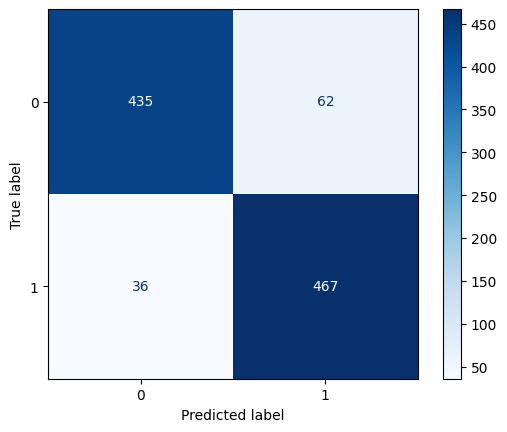

In [45]:
visualizacion = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_prueba_pred))
visualizacion.plot(cmap='Blues');

### Exactitud

In [46]:
print(f'La exactitud del modelo con los datos de prueba es {accuracy_score(y_test, y_prueba_pred)}')

La exactitud del modelo con los datos de prueba es 0.902


### Precisión

In [47]:
print(f'La precisión del modelo con los datos de prueba: {precision_score(y_test, y_prueba_pred)}') 

La precisión del modelo con los datos de prueba: 0.8827977315689981


In [48]:
print(f'La sensibilidad del modelo con los datos de prueba: {recall_score(y_test, y_prueba_pred)}') 

La sensibilidad del modelo con los datos de prueba: 0.9284294234592445


### Curva ROC

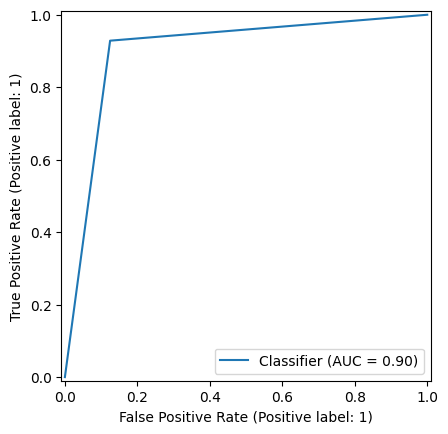

In [49]:
RocCurveDisplay.from_predictions(y_test, y_prueba_pred);




In [50]:
#Gráfico alternativo de la curva ROC
# Generar un predictor sin habilidad
ns_probs = [0 for _ in range(len(y_test))]

# Calculo de la métrica auc
#Predictor sin habilidad
ns_auc = roc_auc_score(y_test, ns_probs)
#Predictor regresión logistica
lr_auc = roc_auc_score(y_test, y_prueba_pred)
# Cáculo de la curva roc
ns_fpr, ns_tpr, t = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, t = roc_curve(y_test, y_prueba_pred)


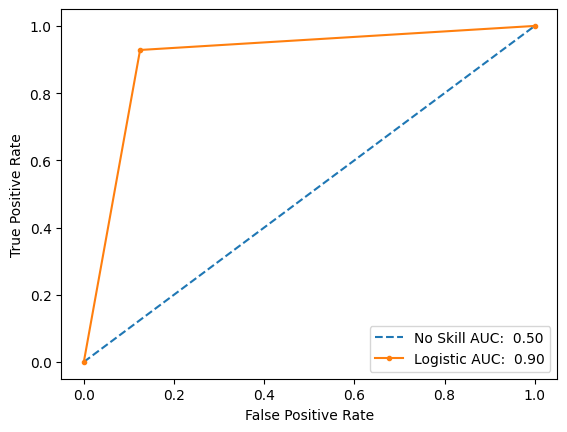

In [51]:

lr_auc = roc_auc_score(y_test, y_prueba_pred)

#Gráfico de la curva ROC
plt.plot(ns_fpr, ns_tpr, linestyle='--', label=f'No Skill AUC: {ns_auc: .2f}')
plt.plot(lr_fpr, lr_tpr, marker='.', label=f'Logistic AUC: {lr_auc: .2f}')

# Etiquetas de los ejes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Mostrar la leyenda
plt.legend()
# Mostrar el gráfico
plt.show()

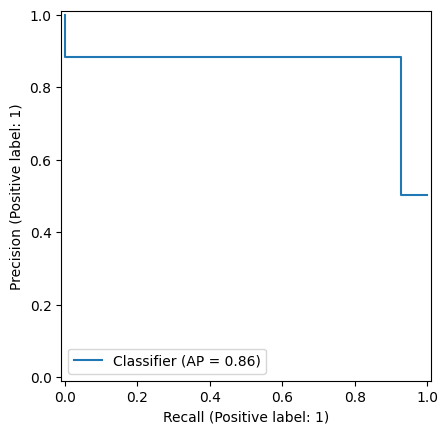

In [52]:
PrecisionRecallDisplay.from_predictions(y_test, y_prueba_pred);

In [53]:
#Cálculo de las métricas recall y precisión
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_prueba_pred)
av_pre_score = round(average_precision_score(y_test, y_prueba_pred),3)
no_skill = len(y_test[y_test==1]) / len(y_test)


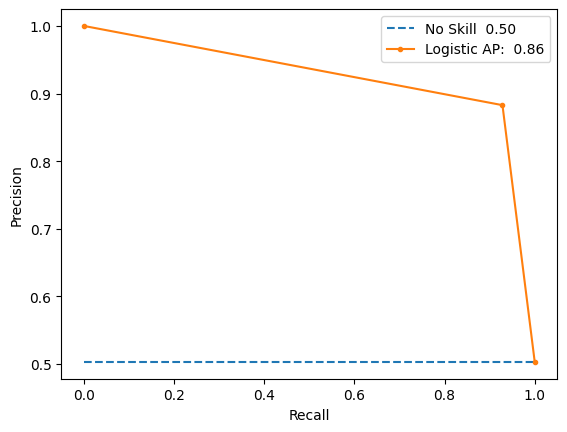

In [54]:
#Gŕafico de curva precision sensibilidad
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill {no_skill: .2f}')
plt.plot(lr_recall, lr_precision, marker='.', label= f'Logistic AP: {av_pre_score: .2f}')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()

plt.show()


### Interpretación  de las métricas y gráficos

En el gráfico ROC, observamos que el modelo tiene una excelente capacidad para distinguir entre las dos clases de churn, respaldado por un AUC de 0.89. Esto significa que el modelo es altamente eficaz separando a los clientes que se irán de los que se quedarán.

Otro aspecto crítico es la estabilidad del modelo: como se ve en la curva Precisión vs Sensibilidad (Recall), a medida que aumentamos la sensibilidad para capturar a más clientes en riesgo, la precisión no decae bruscamente, sino que se mantiene constante y en un valor muy alto, cercano al 90%.

En conclusión, el modelo logra un balance óptimo entre precisión y sensibilidad, permitiéndonos identificar al 90% de los desertores con un margen de error mínimo. Este rendimiento global se resume en el Puntaje Promedio de Precisión (AP) de 0.85, lo que garantiza una alta rentabilidad en las acciones de retención.

## **Serializamos el modelo**

In [55]:
import pickle

with open('modelo.pkl', 'wb') as archivo:
    pickle.dump(lr, archivo)

## **Cargamos el modelo**


In [56]:
with open('modelo.pkl', 'rb') as archivo:
    lr = pickle.load(archivo)

## **Probabilidades / API**

In [57]:
#Probabilidad de que un cliente se vaya (churn=1)
y_proba = lr.predict_proba(X_test)[:, 1]
y_proba[:10]


array([2.83960738e-05, 9.72200504e-01, 8.43498452e-01, 9.85438174e-01,
       9.94056867e-01, 9.84343160e-01, 9.19297235e-01, 9.99944913e-01,
       3.95944407e-01, 7.65044238e-01])

In [58]:
def predict_cliente(input_dict):
    """
    Documentación de la función
    """
    #df con las caracteristicas del cliente a predecir
    df_input = pd.DataFrame([input_dict])
    #Guardamos la variable id
    id = int(df_input['customer_id'].iloc[0])
    #luego la eliminamos del df para que no intervenga en el modelo
    datos_input = df_input.drop(columns=['customer_id'])
    #corremos el modelo
    proba = lr.predict_proba(datos_input)[0, 1]
    pred = "Va a cancelar" if proba >= 0.5 else "Va a continuar"
    # la salida: id junto con la predicción del modelo
    return {
        "customer_id": id,
        "prediction": pred,
        "probability": round(float(proba), 3)
    }
    
    

## **Función de predicción**

### Probar con un cliente / Manual

In [59]:
cliente_ejemplo = {
    "customer_id": 10,
    "subscription_type": "Standard",
    "watch_hours": 3,
    "last_login_days": 1,
    "monthly_fee": 16,
    "number_of_profiles": 2,
    "avg_watch_time_per_day": 0.35,
    "payment_method": "Debit Card"

}

print(f'La predicción del modelo es:{predict_cliente(cliente_ejemplo)}')


La predicción del modelo es:{'customer_id': 10, 'prediction': 'Va a continuar', 'probability': 0.092}
